In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from pymatgen.core import Structure
import json
import gzip
import re
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [3]:
def get_structures(filename, ids=None):
    with gzip.open(Path(structure_dir, filename), 'r') as f:
        data = json.loads(f.read().decode())
        
        if ids is None:
            ids = data.keys()
            
        for key in tqdm(ids):
            if key in data:
                yield {'id': key, 'structure': Structure.from_dict(data[key])}        

In [4]:
structure_dir = Path('/projects/rlmolecule/jlaw/inputs/structures/')
calc_energy = pd.read_csv(Path(structure_dir, 'battery_relaxed_energies.csv'))

## Check the differencew between the original volume DFT run and Prashun's fix
- Prashun found that running one more calculation at the end of DFT has a more correct volume and energy

In [5]:
data = pd.read_csv(Path(structure_dir, "volrelax/battery_volrelaxed_energies.csv"))
data.head(2)

,comp_type,composition,id,energyperatom
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092


In [6]:
data['proto_id'] = data['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
data.head(2)

,comp_type,composition,id,energyperatom,proto_id
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,icsd_033805
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092,icsd_059680


<AxesSubplot:>

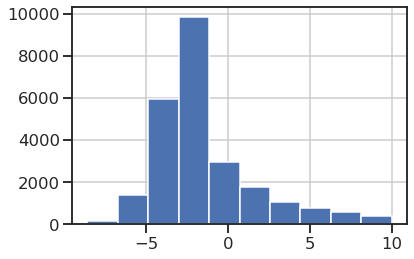

In [26]:
data = data[(data.energyperatom > -10) & (data.energyperatom < 10)]
data['energyperatom'].hist()

In [21]:
new_vol_files = ["_1_3.csv",
                "_2_2_3_3.csv",
                "_2_3_5.csv",
                "_3_3_4.csv",
                ]
new_vol_files = [f"/scratch/jlaw/crystals/{f}" for f in new_vol_files]
new_data = pd.concat([pd.read_csv(f) for f in new_vol_files])
new_data.head(2)

,decoration,energyperatom,volume,numatoms
0,Na3P1_sg71_icsd_167554_1,-2.610,172.3,8
1,Na3P1_sg44_icsd_104488_1,-2.273,192.2,8


In [22]:
new_data[(new_data.energyperatom < -10) | (new_data.energyperatom > 10)]

,decoration,energyperatom,volume,numatoms
517,Na3N1_sg151_icsd_020717_1,-1487.648,529.1,24
656,K3N1_sg140_icsd_034270_1,20.060,240.3,16
671,K3N1_sg72_icsd_027135_1,20.006,180.8,16
677,K3N1_sg88_icsd_030633_1,20.477,388.6,32
751,K3N1_sg166_icsd_001144_1,20.035,168.0,12
833,K3P1_sg72_icsd_027135_1,20.665,185.9,16
878,K3P1_sg166_icsd_001144_1,20.782,172.5,12
903,K3P1_sg88_icsd_030633_1,21.626,402.4,32
919,K3P1_sg140_icsd_034270_1,20.225,243.8,16


<AxesSubplot:>

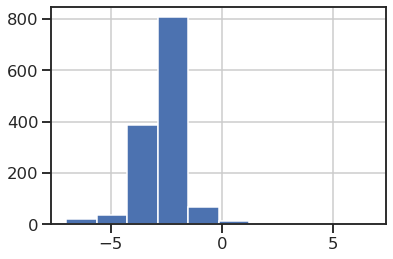

In [23]:
new_data = new_data[(new_data.energyperatom > -10) & (new_data.energyperatom < 10)]
new_data['energyperatom'].hist()

In [27]:
merged_data = pd.merge(data, new_data, left_on='id', right_on='decoration', suffixes=('_orig', '_fix'))
merged_data

,comp_type,composition,id,energyperatom_orig,proto_id,decoration,energyperatom_fix,volume,numatoms
0,_1_3,Na3P1,Na3P1_sg71_icsd_167554_1,-2.479,icsd_167554,Na3P1_sg71_icsd_167554_1,-2.610,172.3,8
1,_1_3,Na3P1,Na3P1_sg44_icsd_104488_1,-2.236,icsd_104488,Na3P1_sg44_icsd_104488_1,-2.273,192.2,8
2,_1_3,Na3P1,Na3P1_sg194_icsd_024569_1,-2.262,icsd_024569,Na3P1_sg194_icsd_024569_1,-2.305,188.2,8
3,_1_3,Na3P1,Na3P1_sg12_icsd_029380_1,-1.047,icsd_029380,Na3P1_sg12_icsd_029380_1,-1.622,328.9,8
4,_1_3,Na3P1,Na3P1_sg216_icsd_629268_1,-2.605,icsd_629268,Na3P1_sg216_icsd_629268_1,-2.621,341.6,16
...,...,...,...,...,...,...,...,...,...
919,_1_3,K3P1,K3P1_sg162_icsd_043292_1,-1.860,icsd_043292,K3P1_sg162_icsd_043292_1,-1.869,369.8,8
920,_1_3,K3P1,K3P1_sg139_icsd_710068_1,-1.622,icsd_710068,K3P1_sg139_icsd_710068_1,-1.690,1237.7,32
921,_1_3,K3P1,K3P1_sg18_icsd_026765_1,-1.715,icsd_026765,K3P1_sg18_icsd_026765_1,-1.741,668.6,16
922,_1_3,K3P1,K3P1_sg216_icsd_629268_1,-2.278,icsd_629268,K3P1_sg216_icsd_629268_1,-2.334,510.1,16


In [13]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [14]:
def dss_scatter(df, x, y, ax, xrange=None, yrange=None, xlabel='', ylabel=''):
    # xrange = (0, df[x].max()) if not xrange else xrange
    # yrange = (0, df[y].max()) if not yrange else yrange
    dsshow(df, ds.Point(x, y),
       ax=ax, shade_hook=dstf.dynspread, 
           cmap='Blues', norm='eq_hist', aspect='auto', 
           y_range=yrange, x_range=xrange)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    # also compute the MAE and add it to the plot
    # mae = mean_absolute_error(df.dropna()[x], df.dropna()[y])
    # ax.text(1, 0.925, f'MAE: {mae:.1f} vol/atom',
    #     ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

In [ ]:
sns.set_context('talk')

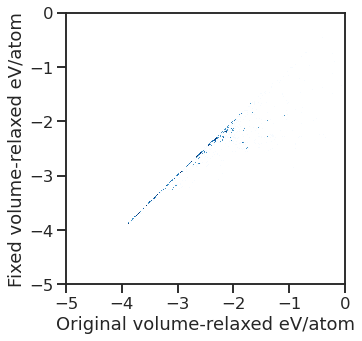

In [ ]:
f, ax = plt.subplots(figsize=(5,5))
dss_scatter(merged_data, 
            'energyperatom_orig', 'energyperatom_fix', ax, 
            xrange=(-5, 0), yrange=(-5, 0), 
            xlabel='Original volume-relaxed eV/atom', 
            ylabel='Fixed volume-relaxed eV/atom')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Fixed vol-relaxed eV/atom')

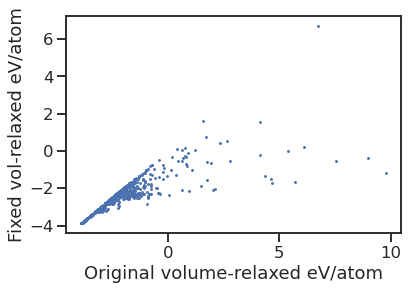

In [35]:
ax = merged_data.plot.scatter(
                'energyperatom_orig', 'energyperatom_fix',
    s=2,
)
ax.set_xlabel('Original volume-relaxed eV/atom')
ax.set_ylabel('Fixed vol-relaxed eV/atom')

In [ ]:
# also check the factor of change in volume
